In [96]:
import pandas as pd
import sys
sys.path.insert(0, "/media/diskD/EPFL/Fall 2016/ADA/Project/GMR_ADA_Project/EmotionAnalysis")
from DataSchemaExtractionParsing import *
from DataPreProcessing import *
from SentSemanticModule import *
from SentTweetModule import *
from SentSyntacticModule import *
import ast
%matplotlib inline
from collections import Counter
from sklearn.model_selection import train_test_split

# I. Affective Representation of Annotated Dataset:

### Loading Annotated Dataset

In [2]:
plutchik_tweets = pd.read_csv('Data/primary-plutchik-wheel-DFE.csv',encoding="utf-8")
plutchik_tweets = plutchik_tweets[['text','emotion']]
plutchik_tweets.head()

,text,emotion
0,How much of the forecast was genuine and how m...,Neutral
1,I did touch them one time you see but of cours...,Neutral
2,We find that choice theorists admit that they ...,Neutral
3,"Well, here I am with an olive branch.",Neutral
4,"Its rudder and fin were both knocked out, and ...",Neutral


In [3]:
len(plutchik_tweets)

2524

In [4]:
set(plutchik_tweets['emotion'])

{u'Aggression',
 u'Ambiguous',
 u'Anger',
 u'Anticipation',
 u'Awe',
 u'Contempt',
 u'Disapproval',
 u'Disgust',
 u'Fear',
 u'Joy',
 u'Love',
 u'Neutral',
 u'Optimism',
 u'Remorse',
 u'Sadness',
 u'Submission',
 u'Surprise',
 u'Trust'}

In [55]:
selective_8 = ['Anger','Anticipation','Disgust','Fear','Joy','Sadness','Surprise','Trust','Neutral']
plutchik_tweets_8emotions = plutchik_tweets[plutchik_tweets['emotion'].isin(selective_8)]
len(plutchik_tweets_8emotions)

1483

## Visualizing the distribution of emotions in the annotated dataset:

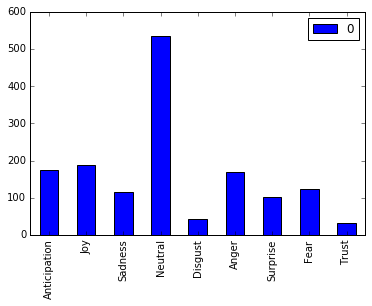

In [56]:
frequency = Counter(plutchik_tweets_8emotions['emotion'])
df = pd.DataFrame.from_dict(frequency, orient='index')
df.plot(kind='bar')

### Applying the same pre-processing pipeline to get affective representation:

In [57]:
tweets_no_contractions = replace_contractions(plutchik_tweets_8emotions)

### Tokenization of Sentences into words

In [58]:
tokenized_list = bag_of_word_representation(tweets_no_contractions)

### Part of Speech Tagging:

In [59]:
tagged_tweets = pos_tagging(tokenized_list)

### Dependency Parser:

In [9]:
nlp = spacy.load('en')

In [60]:
docs = []
# Joining text:
tweets_text = []
for i in range(0, len(tokenized_list)):
    space = " "
    tweets_text.append(space.join(tokenized_list[i]))
tweets_text[0].encode("utf-8")
for i in range(0, len(tweets_text)):
    doc = nlp(tweets_text[i])
    docs.append(doc)

In [61]:
new_samples = []
for sample in docs:
    new_samples_sub = []
    for word in sample:
        new_samples_sub.append((unicode(word),word.pos_))
    new_samples.append(new_samples_sub)

### Application of Syntactic Rules

In [62]:
new_samples,triple_dependencies = apply_syntactic_rules(docs,new_samples)

In [63]:
i = 2
print "\n<<<< Original tweet text >>>\n"
print tweets_text[i]
print "\n<<<< Syntactic dependencies >>>\n"
print triple_dependencies[i]
print "\n<<<< Tweet after applying syntactic Rules >>>\n"
#print new_samples[i]
new_tweet = []
for (word,pos) in new_samples[i]:
    new_tweet.append(word)
print new_tweet


<<<< Original tweet text >>>

We find that choice theorists admit that they introduce a style of moral paternalism at odds with liberal values

<<<< Syntactic dependencies >>>

[(We, u'nsubj', find), (find, u'ROOT', find), (that, u'mark', admit), (choice, u'compound', theorists), (theorists, u'nsubj', admit), (admit, u'ccomp', find), (that, u'mark', introduce), (they, u'nsubj', introduce), (introduce, u'ccomp', admit), (a, u'det', style), (style, u'dobj', introduce), (of, u'prep', style), (moral, u'amod', paternalism), (paternalism, u'pobj', of), (at, u'prep', introduce), (odds, u'pobj', at), (with, u'prep', odds), (liberal, u'amod', values), (values, u'pobj', with)]

<<<< Tweet after applying syntactic Rules >>>

[u'We', u'find', u'that', u'choice', u'theorists', u'admit', u'that', u'they', u'introduce', u'a', u'style', u'of', u'moral', u'at', u'odds', u'with', u'liberal']


### Named Entity Recognition:

In [64]:
tweet_without_ne = remove_named_entities(new_samples)

### Normalizing POS Tags

In [65]:
normalized_tags = normalize_pos_tags_words(tweet_without_ne)
normalized_tags[1]

[(u'I', u'PRON'),
 (u'did', 'v'),
 (u'touch', 'v'),
 (u'them', u'PRON'),
 (u'one', u'NUM'),
 (u'time', 'n'),
 (u'you', u'PRON'),
 (u'see', 'v'),
 (u'but', u'CONJ'),
 (u'of', u'ADP'),
 (u'course', 'n'),
 (u'there', u'ADV'),
 (u'was', 'v'),
 (u'nothing', 'n'),
 (u'doing', 'v'),
 (u'he', u'PRON'),
 (u'wanted', 'v'),
 (u'me', u'PRON')]

### Removal of Punctuation and Stop words and Converting to Lower Case and Removal of Other special categories: url, number, username:

In [66]:
tagged_tweets_without = eliminate_stop_words_punct(normalized_tags)

### Lemmatization:

In [67]:
lemmatized_tweets = lemmatizer(tagged_tweets_without)

lemmatized_tweets_untag = lemmatizer_untagged(tagged_tweets_without)
lemmatized_tweets[0]

[(u'much', u'ADJ'),
 (u'forecast', 'n'),
 (u'genuine', u'ADJ'),
 (u'much', u'ADJ'),
 (u'fix', 'v'),
 (u'moot', u'ADJ')]

### Keeping only NAVA words

In [68]:
nava_tweets = keep_only_nava_words(lemmatized_tweets)

In [69]:
print lemmatized_tweets[0]
print nava_tweets[0]

[(u'much', u'ADJ'), (u'forecast', 'n'), (u'genuine', u'ADJ'), (u'much', u'ADJ'), (u'fix', 'v'), (u'moot', u'ADJ')]
[u'much', u'forecast', u'genuine', u'much', u'fix', u'moot']


### Storing affective word level representation:

In [70]:
annotated_nava_tweets_df = pd.DataFrame()
annotated_nava_tweets_df['Nava Representation'] = nava_tweets
annotated_nava_tweets_df['Tokenized Lemmatized'] = lemmatizer_raw(tagged_tweets)

annotated_nava_tweets_df.to_csv('Results/Annotated_Representation.csv')

### USE THIS TO LOAD DIRECTLY ALREADY FINISHED RAW TOKENIZED LEMMATIZED REPRESENTATION

In [71]:
annotated_tweets_df = pd.read_csv('Results/Annotated_Representation.csv')
tokenized_lemma_representation = annotated_tweets_df['Tokenized Lemmatized']
tokenized_lemmatized_tweets = []
for i in range(0, len(tokenized_lemma_representation)):
    result = ast.literal_eval(tokenized_lemma_representation[i])
    tokenized_lemmatized_tweets.append(result)

### USE THIS TO LOAD DIRECTLY ALREADY FINISHED AFFECTIVE REPRESENTATION

In [72]:
annotated_tweets_df = pd.read_csv('Results/Annotated_Representation.csv')
affective_representation = annotated_tweets_df['Nava Representation']
nava_tweets = []
for i in range(0, len(affective_representation)):
    result = ast.literal_eval(affective_representation[i])
    nava_tweets.append(result)

# II. Loading Unannotated Tweets

### 1. Loading Raw Lemmatized Representation:

In [73]:
annotated_tweets_df = pd.read_csv('Results/Unannotated_Representation.csv')
tokenized_lemma_representation = annotated_tweets_df['Tokenized Lemmatized']
unnatoted_tokenized_lemmatized_tweets = []
for i in range(0, len(tokenized_lemma_representation)):
    result = ast.literal_eval(tokenized_lemma_representation[i])
    unnatoted_tokenized_lemmatized_tweets.append(result)

### 2. Loading Nava Affective Representation:

In [74]:
unannotated_tweets_df = pd.read_csv('Results/Unannotated_Representation.csv')
affective_representation = unannotated_tweets_df['Nava Tweets']
unannotated_nava_tweets = []
for i in range(0, len(affective_representation)):
    result = ast.literal_eval(affective_representation[i])
    unannotated_nava_tweets.append(result)

# III. Word to Numerical Vector Representation:

### 1. Combining the small annotated dataset and whole unannotated tweets

In [75]:
tokenized_lemma_whole = tokenized_lemmatized_tweets + unnatoted_tokenized_lemmatized_tweets  

In [7]:
import pandas as pd
tokenized = pd.read_csv('../../Project_Backup/BigData/Unannotated_Representation_whole.csv')

In [12]:
# Convert tokenized_lemma
from tqdm import tqdm
import ast
tokenized_lemma = tokenized['Tokenized Lemmatized']
tokenized_lemmatized_tweets = []
for i in tqdm(range(0, len(tokenized_lemma))):
    result = ast.literal_eval(tokenized_lemma[i])
    tokenized_lemmatized_tweets.append(result)

100%|█████████████████████████████| 2985994/2985994 [03:12<00:00, 15509.30it/s]


### 2. Training word2Vec on the combined list

In [14]:
# PARAMETERS TO BE TUNED:

# Word vector dimensionality                      
# Minimum word count                        
# Number of threads to run in parallel
# Context window size                                                                                    
# Downsample setting for frequent words

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality
min_word_count = 1  # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
model = word2vec.Word2Vec(tokenized_lemmatized_tweets, workers=num_workers,
            size=num_features, min_count = min_word_count,
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "Models/whole_en_model"
model.save(model_name)


C:\Users\fnac\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
2017-01-18 17:38:55,646 : INFO : 'pattern' package not found; tag filters are not available for English


Training model...


2017-01-18 17:38:55,710 : INFO : collecting all words and their counts
2017-01-18 17:38:55,718 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-01-18 17:38:55,784 : INFO : PROGRESS: at sentence #10000, processed 103413 words, keeping 12272 word types
2017-01-18 17:38:55,834 : INFO : PROGRESS: at sentence #20000, processed 211455 words, keeping 19346 word types
2017-01-18 17:38:55,885 : INFO : PROGRESS: at sentence #30000, processed 315613 words, keeping 24799 word types
2017-01-18 17:38:55,936 : INFO : PROGRESS: at sentence #40000, processed 423845 words, keeping 29711 word types
2017-01-18 17:38:55,990 : INFO : PROGRESS: at sentence #50000, processed 529457 words, keeping 33974 word types
2017-01-18 17:38:56,039 : INFO : PROGRESS: at sentence #60000, processed 632605 words, keeping 38518 word types
2017-01-18 17:38:56,087 : INFO : PROGRESS: at sentence #70000, processed 739206 words, keeping 42801 word types
2017-01-18 17:38:56,136 : INFO : PROGRESS: at 

In [16]:
print (model.similarity('dead','humour'))
#print model.similarity('write','print')

0.0365886882817


In [4]:
from gensim.models import Word2Vec
model = Word2Vec.load('C:/Users/fnac/Fall 2016/ADA/Project_Backup/BigData/Models/whole_en_model')

In [ ]:
import pandas as pd 
from tqdm import tqdm
import ast
tweets_df = pd.read_csv('../../Project_Backup/BigData/Unannotated_Representation/en/Unannotated_Representation_whole.csv')

#tweets_df = tweets_df[1000000:len(tweets_df)]

nava_repr = list(tweets_df['Nava Representation'])

print ("Converting NAVA Tweets to List")
# Convert nava_tweets
nava_tweets = []
for i in tqdm(range(0, len(nava_repr))):
    result = ast.literal_eval(nava_repr[i])
    nava_tweets.append(result)

In [18]:
len(nava_tweets)

10

In [6]:
print (model.similarity('happy','sad'))

0.436054647174


## 2. Visualizing the word2vec model using tsNE dimensionality reduction: TODO

## 3. Trying Dimensionality Reduction

## 4. Word2Vec Representation:

In [78]:
AnnotatedTweets = getAvgFeatureVecs(nava_tweets, model, 300)

In [79]:
UnAnnotatedTweets = getAvgFeatureVecs(unannotated_nava_tweets, model, 300)

## 5. Second Option: Word to Vector Representation Using FastText:

### Preparing text file for training: 

In [318]:
space = ' '
text = []
for tokenized_lemma in tokenized_lemma_whole:
    text.append(space.join(tokenized_lemma))
whole_text = space.join(text)
len(whole_text)
# Storing it in file:
text_file = open("Results/fast_text.txt", "w")
text_file.write(whole_text)
text_file.close()

In [2]:
import fasttext

# Loading Skipgram model
model = fasttext.load_model('fast_text_skip_gram.bin')

ValueError: fastText: trained model cannot be opened!

# IV. Training ER models using Machine Learning Algorithms in an Semi-Supervised Manner

* Rational: 
A method for adapting consists in iteratively "auto-labeling" the target examples.
    * a model h is learned from the labeled source examples
    * h automatically labels SOME target examples;
    * a new model is learned from the new labeled examples.

* Trying the following Algorithms with domain adaptation:
    * Random Forest
    * GBM
    * Support Vector Machine with different kernels: linear, radial, polynomial.
    * Naive Bayes: bernoulli,gaussian, multinomial
    * Maximum Entropy 
    * K-nearest Neighbors
    * Decision Trees
* Fine Tuning model parameters:
* Model Evaluation through Cross Validation: 
* Confusion Matrices
* Learning Curves
* Voted Model between Different Algorithms + Lexicon Based

In [283]:
emo_dict = {
    'Anger':0,
    'Anticipation':1,
    'Disgust':2,
    'Fear':3,
    'Joy':4,
    'Sadness':5,
    'Surprise':6,
    'Trust':7,
    'Neutral':8
}
plutchik_tweets_8emotions['emotionId'] = [emo_dict[emotion] for emotion in plutchik_tweets_8emotions['emotion']]

/home/meryem/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## 1. Splitting X and y into training and testing:

In [284]:
X_train, X_test, y_train, y_test = train_test_split(AnnotatedTweets,plutchik_tweets_8emotions['emotionId'], test_size=0.3)

In [285]:
# Dealing with Unbalanced Classes:
def weight_sample(labels):
    """ We calculate the percentages for each class and add it to the sample_weights list"""
    
    weight_class = labels.value_counts()/len(labels)
    
    sample_weights = []
    for i in labels:
        sample_weights += [weight_class[i]]
        
    return np.array(sample_weights)

sample_weights = weight_sample(y_train)

## 2. Trying Random Forest:

In [286]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
forest = RandomForestClassifier( n_estimators = 15, max_features = None )

# Training and predicting for only annotated dataset:
print ("Fitting a random forest to labeled training data....")
forest = forest.fit(X_train, y_train,sample_weight= sample_weights) 
result_train = forest.predict(X_train)
result_test = forest.predict(X_test)

iteration = 1
# Training and predicting using domain adaptation in an iterative fashion:
for i in xrange(0,3000,1000):
    print ("Fitting a random forest to training data using domain adaptation, ITERATION: "+str(iteration))
    
    # Predicting on a small subset of the unannotated dataset:
    subset_results = forest.predict(UnAnnotatedTweets[0+i:1000+i])
    X_train = np.concatenate((X_train,UnAnnotatedTweets[0+i:1000+i]))
    y_train = np.concatenate((y_train,subset_results))
    
    # Retraining model on the new annotated dataset:
    
    forest = forest.fit(X_train, y_train) 
    result_train = forest.predict(X_train)
    
    iteration = iteration + 1

result_test = forest.predict(X_test) # New Predictions for test dataset    

Fitting a random forest to labeled training data....
Fitting a random forest to training data using domain adaptation, ITERATION: 1
Fitting a random forest to training data using domain adaptation, ITERATION: 2
Fitting a random forest to training data using domain adaptation, ITERATION: 3


In [287]:
import matplotlib.pyplot as plt
from sklearn import metrics
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

### Plotting Confusion Matrix for Training:

In [288]:
cm=metrics.confusion_matrix(y_train, result_train)
print(cm)

[[ 305    0    0    0    0    0    0    0    7]
 [   1  368    0    0    0    0    0    0    2]
 [   1    0   26    0    0    0    0    0    0]
 [   0    1    0  172    0    0    0    0    3]
 [   0    1    0    0  496    0    1    0    4]
 [   0    0    0    0    0  119    0    0    1]
 [   0    0    0    1    0    0   80    0    2]
 [   0    0    0    0    0    0    0   21    1]
 [   1    0    0    0    0    0    0    1 2423]]


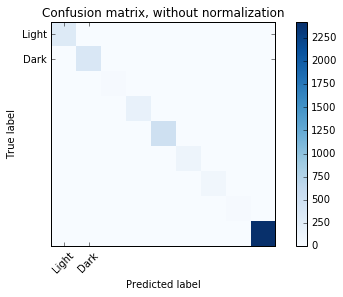

In [289]:
plot_confusion_matrix(cm, classes=['Light','Dark'],
                      title='Confusion matrix, without normalization')

## Plotting Confusion Matrix for Testing:

In [290]:
cm_test=metrics.confusion_matrix(y_test, result_test)
print(cm_test)

[[  9   7   0   1   1   1   1   0  21]
 [  6   8   0   1   2   0   1   0  32]
 [  4   0   0   0   3   1   0   0  10]
 [  3   3   0   3   2   1   0   0  25]
 [  4   5   0   0  11   0   0   0  31]
 [  2   1   1   1   4   0   0   0  21]
 [  1   4   0   1   2   1   2   0  25]
 [  5   0   0   0   0   0   0   0  10]
 [ 12  12   1   1   6   3   1   0 131]]


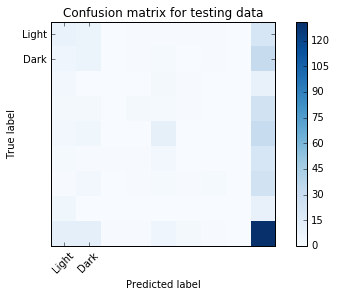

In [291]:
plot_confusion_matrix(cm_test, classes=['Light','Dark'],
                      title='Confusion matrix for testing data')

### Model Evaluation: 

### For Training:

In [293]:
print('Accuracy Score: ',metrics.accuracy_score(y_train, result_train))

print('micro Precision Score: ',metrics.precision_score(y_train, result_train, average='micro'))
print('micro Recall Score: ',metrics.recall_score(y_train, result_train, average='micro'))
print('micro f1_score: ',metrics.f1_score(y_train, result_train, average='micro'))

print('macro Precision Score: ',metrics.precision_score(y_train, result_train, average='macro'))
print('macro Recall Score: ',metrics.recall_score(y_train, result_train, average='macro'))
print('macro f1_score: ',metrics.f1_score(y_train, result_train, average='macro'))


# Customized Version of AUC for multiple classes
fpr, tpr, thresholds = metrics.roc_curve(y_train, result_train, pos_label=9)
print('roc_auc_score: ',metrics.auc(fpr, tpr))

('Accuracy Score: ', 0.99306587419514614)
('micro Precision Score: ', 0.99306587419514614)
('micro Recall Score: ', 0.99306587419514614)
('micro f1_score: ', 0.99306587419514614)
('macro Precision Score: ', 0.99034301197950114)
('macro Recall Score: ', 0.97855601653625435)
('macro f1_score: ', 0.98437428152454942)
('roc_auc_score: ', nan)


### For Testing:

In [297]:
print('Accuracy Score: ',metrics.accuracy_score(y_test, result_test))

print('micro Precision Score: ',metrics.precision_score(y_test, result_test, average='micro'))
print('micro Recall Score: ',metrics.recall_score(y_test, result_test, average='micro'))
print('micro f1_score: ',metrics.f1_score(y_test, result_test, average='micro'))

print('macro Precision Score: ',metrics.precision_score(y_test, result_test, average='macro'))
print('macro Recall Score: ',metrics.recall_score(y_test, result_test, average='macro'))
print('macro f1_score: ',metrics.f1_score(y_test, result_test, average='macro'))


# Customized Version of AUC for multiple classes
fpr, tpr, thresholds = metrics.roc_curve(y_test, result_test, pos_label=9)
print('roc_auc_score: ',metrics.auc(fpr, tpr))

('Accuracy Score: ', 0.36853932584269661)
('micro Precision Score: ', 0.36853932584269661)
('micro Recall Score: ', 0.36853932584269661)
('micro f1_score: ', 0.36853932584269661)
('macro Precision Score: ', 0.21706616208376242)
('macro Recall Score: ', 0.16847402711032697)
('macro f1_score: ', 0.15975250293842558)
('roc_auc_score: ', nan)


## Labelling Our Geo-Tweets Using Random Forest:

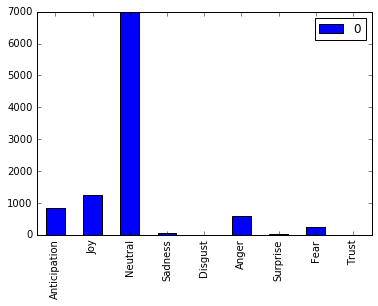

In [298]:
resultUnannotatedTweets = forest.predict(UnAnnotatedTweets)
resultUnannotatedTweets_df = pd.DataFrame()
resultUnannotatedTweets_df['Emotion_Id'] = resultUnannotatedTweets

emo_dict = {
    0: 'Anger',
    1: 'Anticipation',
    2: 'Disgust',
    3: 'Fear',
    4: 'Joy',
    5: 'Sadness',
    6: 'Surprise',
    7: 'Trust',
    8: 'Neutral'
}

resultUnannotatedTweets_df['Emotion'] = [emo_dict[emotion_id] for emotion_id in resultUnannotatedTweets_df['Emotion_Id'] ]
frequency = Counter(resultUnannotatedTweets_df['Emotion'])
df = pd.DataFrame.from_dict(frequency, orient='index')
df.plot(kind='bar')

## 3. Trying SVM with Different Kernels: (linear, radial, polynomial)
Separating hyperplane for unbalanced classes

In [307]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
C = 1.0 # PARAMETERS TO BE FINE TUNED 
gamma = 0.7 # PARAMETERS TO BE FINE TUNED
degree = 9 # PARAMETERS TO BE FINE TUNED
lin_svc = svm.SVC(kernel='linear', C=C, class_weight={1: 9}).fit(X_train, y_train)
rbf_svc = svm.SVC(kernel='rbf', gamma=gamma, C=C,class_weight={1: 9}).fit(X_train, y_train)
poly_svc = svm.SVC(kernel='poly', degree=degree, C=C).fit(X_train, y_train)

In [308]:
result_train_svm_lin = lin_svc.predict(X_train)
result_test_svm_lin = lin_svc.predict(X_test)

In [309]:
result_train_svm_rbf = rbf_svc.predict(X_train)
result_test_svm_rbf = rbf_svc.predict(X_test)

In [310]:
result_train_svm_poly = poly_svc.predict(X_train)
result_test_svm_poly = poly_svc.predict(X_test)

## Labelling Our Geo-Tweets Using Linear SVM:

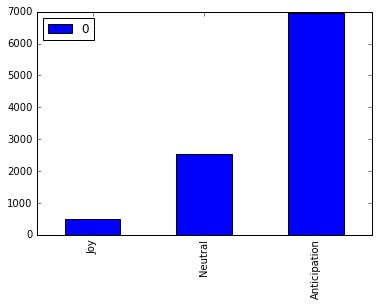

In [312]:
resultUnannotatedTweets = lin_svc.predict(UnAnnotatedTweets)
resultUnannotatedTweets_df = pd.DataFrame()
resultUnannotatedTweets_df['Emotion_Id'] = resultUnannotatedTweets

resultUnannotatedTweets_df['Emotion'] = [emo_dict[emotion_id] for emotion_id in resultUnannotatedTweets_df['Emotion_Id'] ]
frequency = Counter(resultUnannotatedTweets_df['Emotion'])
df = pd.DataFrame.from_dict(frequency, orient='index')
df.plot(kind='bar')

### Model Evaluation: 

### For Training:

In [272]:
print('Accuracy Score: ',metrics.accuracy_score(y_train, result_train_svm))

print('micro Precision Score: ',metrics.precision_score(y_train, result_train_svm, average='micro'))
print('micro Recall Score: ',metrics.recall_score(y_train, result_train_svm, average='micro'))
print('micro f1_score: ',metrics.f1_score(y_train, result_train_svm, average='micro'))

print('macro Precision Score: ',metrics.precision_score(y_train, result_train_svm, average='macro'))
print('macro Recall Score: ',metrics.recall_score(y_train, result_train_svm, average='macro'))
print('macro f1_score: ',metrics.f1_score(y_train, result_train_svm, average='macro'))


# Customized Version of AUC for multiple classes
fpr, tpr, thresholds = metrics.roc_curve(y_train, result_train_svm, pos_label=10)
print('roc_auc_score: ',metrics.auc(fpr, tpr))

('Accuracy Score: ', 0.63397721644378402)
('micro Precision Score: ', 0.63397721644378402)
('micro Recall Score: ', 0.63397721644378402)
('micro f1_score: ', 0.63397721644378402)
('macro Precision Score: ', 0.58142407484252123)
('macro Recall Score: ', 0.23550161508731091)
('macro f1_score: ', 0.23888227421443237)
('roc_auc_score: ', 0.71729587277127349)


### For Testing:

In [3]:
print('Accuracy Score: ',metrics.accuracy_score(y_test, result_test_svm))

print('micro Precision Score: ',metrics.precision_score(y_test, result_test_svm, average='micro'))
print('micro Recall Score: ',metrics.recall_score(y_test, result_test_svm, average='micro'))
print('micro f1_score: ',metrics.f1_score(y_test, result_test_svm, average='micro'))

print('macro Precision Score: ',metrics.precision_score(y_test, result_test_svm, average='macro'))
print('macro Recall Score: ',metrics.recall_score(y_test, result_test_svm, average='macro'))
print('macro f1_score: ',metrics.f1_score(y_test, result_test_svm, average='macro'))


# Customized Version of AUC for multiple classes
fpr, tpr, thresholds = metrics.roc_curve(y_test, result_test_svm, pos_label=10)
print('roc_auc_score: ',metrics.auc(fpr, tpr))

NameError: name 'metrics' is not defined